See notebook 4.1 for the description of the tutorial. This notebook contains step (5). 

In [7]:
import os
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.optimize import curve_fit
from astropy.table import Table
from jjmodel.constants import tp,tr
from jjmodel.tools import Timer, rebin_histogram
from jjmodel.input_ import p, a, inp
from jjmodel.funcs import IMF, SFR, AMR
from jjmodel.analysis import GetPopulations, agehist, rhoz_monoage, methist
from jjmodel.mwdisk import disk_builder
from jjmodel.populations import stellar_assemblies_r
from jjmodel.plotting import Plotting


fnt1, fnt2 = 16, 12 
label_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


## Step 5. Consistency check. RC metallicity distributions 

If during the current iteration we performed population synthesis using the AMR derived 
with z or z+warp correction, we also use the corresponding z_weights to calculate 
the thin-disk metallicity distributions.
For both thin and thick disk, we also convolve the predicted cumulative metallicity distributions 
with the Gaussian kernel with Gaussian kernels with sigma_FeH derived from the data in the notebook 4.1, 
such that we reproduce the metal-rich end of each distribution. 


In [2]:

# Read the AMR tables

amrd_raw = np.loadtxt(os.path.join(a.T['mettab'],'AMRd_apogee_rc_dr16_zw.txt')).T
amrt_raw = np.loadtxt(os.path.join(a.T['mettab'],'AMRt_apogee_rc_dr16.txt')).T

# first column is time
AMRd_raw = amrd_raw[1:] 
AMRt_raw = amrt_raw[1]   


In [3]:
# Define abundance and spatial grids
# -------------------------------------------

# Create metallicity grid
dFeH2 = 0.05
FeH_bins_hist2 = np.arange(-1,0.6 + dFeH2,dFeH2)
FeH_bins_histc2 = np.add(FeH_bins_hist2,dFeH2/2)[:-1]

# Define lower and upper z where RC stars are selected, pc
zlow_d, zup_d = 0, 2000   # pc
zlow_t, zup_t = 0, 2000   # pc
Rmin_t, Rmax_t = 4, 14    # kpc



In [4]:
# Functions
# ------------------------------

def f_p1(r,p0,p1):
    # 1st-order polynom
    par = p0 + p1*(r/p.Rsun)
    return par

def f_p1_fehp(r,p01,p11,p12):
    # const + line for the radial profile of FeHp parameter
    p11 = 0 
    p02 = p01 + (p11-p12)*R_br2[0]/p.Rsun
    if r <= R_br2[0]:
        par = p01 + p11*(r/p.Rsun)
    else:
        par = p02 + p12*(r/p.Rsun)
    return par

def f_amrd5n(t,t01,r1,t02,r2,FeH_0,FeH_p,aw):
    # Thin-disk AMR eq.
    FeH = FeH_0 + (FeH_p - FeH_0)*\
          (aw*np.tanh(t/t01)**r1/np.tanh(tp/t01)**r1 + (1-aw)*np.tanh(t/t02)**r2/np.tanh(tp/t02)**r2)
    return FeH

def amrt_sj21n(t,t0,r,FeH_0,FeH_p):
    # Law to fit the thick-disk AMR
    FeH = FeH_0 + (FeH_p - FeH_0)*np.tanh(np.divide(t,t0))**r/np.tanh(np.divide(tp,t0))**r
    return FeH


# Analytic AMR
# --------------------------------

# Thin disk 
# Best parameters (end of notebook 4.2)

R_br1 = [7.5,9.75]
R_br2 = [6.0,9.75]
R_int1 = [p.Rmin-1] + R_br1 + [p.Rmax+1]
R_int2 = [p.Rmin-1] + R_br2 + [p.Rmax+1]

rd1_fit = 0.5
rd2_fit = 1.5
feh0_fit = -0.81
popt_aw_mix = [0.99,-0.43]
popt_fehp_mix = [0.41,1,-0.59]
popt_t01_mix = [[-0.32,2.04],[4.99,-2.71],[7.14,-3.91]]
popt_t02_mix = [[-5.29,15.89],[-3.04,7.77],[9.96,-2.79]]


AMRd_pfit = np.zeros((a.Rbins,a.jd))
for i in range(a.Rbins):
    k1 = int(len(np.where(R_int1<a.R[i])[0]) - 1)   
    k2 = int(len(np.where(R_int2<a.R[i])[0]) - 1)     
    AMRd_pfit[i] = f_amrd5n(a.t,f_p1(a.R[i],*popt_t01_mix[k1]),rd1_fit,
                                f_p1(a.R[i],*popt_t02_mix[k2]),rd2_fit,feh0_fit,
                                f_p1_fehp(a.R[i],*popt_fehp_mix),f_p1(a.R[i],*popt_aw_mix))

# Thick disk 

t0 = 0.9
rt = 1.28
FeH0 = -0.91
FeHp = 0.04

AMRt_fit = amrt_sj21n(a.t[:a.jt],t0,rt,FeH0,FeHp)

    

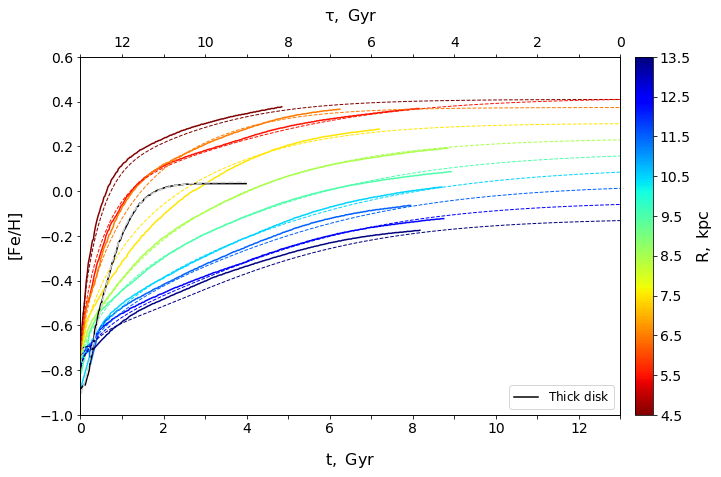

In [19]:

def get_max_age_index(array):
    # Returns max time index of the updated AMR up to which the AMR can be used for fitting. 
    # A sub-array AMR[ind_age:] is filled with constant AMR[ind_age], which means that 
    # the routine for AMR reconstruction doesn't have enough data to get the AMR shape there 
    # (because some ages are not present in RC sample, see the age distribution plots above). 
    
    ind_age = []
    age_max = 12  # Gyr, max age up to which use AMR for fitting, 
                  # regardless of the derived AMR shape 
    for i in range(len(array)):
        d_array = np.diff(array[i])
        index = np.where(np.abs(d_array)>1e-3)[0][-1]
        if index > int(age_max//tr):
            ind_age.append(int(age_max//tr))
        else:
            ind_age.append(index)
    return ind_age


def plot_amr_and_fit(R,amrd_data,ia,amrd_fit,amrt_data,amrt_fit,figname):
    # Plots the reconstructed AMR (thin and thick disk) and their fits
   
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_xlim((0,tp))
    ax.set_ylim((-1.0,0.6))
    ax.set_xticks(np.arange(tp+1))
    ax.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''])
    ax.set_xlabel('$\mathrm{t, \ Gyr}$',fontsize=fnt1,labelpad=15)
    ax.set_ylabel('$\mathrm{[Fe/H]}$',fontsize=fnt1,labelpad=15)
    axx = ax.twiny()
    axx.set_xticks(np.arange(tp+1))
    axx.set_xticklabels(['0','','2','','4','','6','','8','','10','','12',''][::-1])
    axx.set_xlabel(r'$\mathrm{\tau, \ Gyr}$',fontsize=fnt1,labelpad=15)
    fig.subplots_adjust(left=0.11,top=0.86,bottom=0.15,right=0.86)

    line_segments1 = LineCollection([list(zip(a.t[:ia[i]],amrd_data[i][:ia[i]])) for i in np.arange(len(R))],
                                     linewidths=1.5,cmap = mpl.cm.jet_r,
                                     norm = mpl.colors.Normalize(vmin=R[0],vmax=R[-1]))   
    line_segments2 = LineCollection([list(zip(a.t,amrd_fit[i])) for i in np.arange(len(R))],
                                     linewidths=1,ls='--',cmap = mpl.cm.jet_r,
                                     norm = mpl.colors.Normalize(vmin=R[0],vmax=R[-1]))
    line_segments1.set_array(R)
    im = ax.add_collection(line_segments1)
    line_segments2.set_array(R)
    im = ax.add_collection(line_segments2)
    ax.plot(a.t[:a.jt],amrt_data,lw=1.5,c='k',label='$\mathrm{Thick \ disk}$')
    ax.plot(a.t[:a.jt],amrt_fit,lw=1.5,ls='--',c='lightgrey')
    ax.legend(loc=4,prop={'size':fnt2})
    pos = ax.get_position()
    cax = fig.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
    cbar = fig.colorbar(im,cax=cax,orientation='vertical')
    cbar.set_ticks(R)
    cbar.set_label('$\mathrm{R, \ kpc}$',fontsize=fnt1)
    plt.show()
    fig.savefig(os.path.join(a.T['metplt'],''.join(('AMRdt_',figname,'.pdf'))))


plot_amr_and_fit(a.R,AMRd_raw,get_max_age_index(AMRd_raw),AMRd_pfit,AMRt_raw,AMRt_fit,'fit_dm')
    

In [9]:
# Calculate stellar assemblies for the 'raw' AMR and its analytic fit 
#---------------------------------------------------------------------

# Run this and the next block twice, for mode='raw' and mode='fit'

mode = 'fit'

if mode=='raw':
    inp['AMRd'] = AMRd_raw 
    inp['AMRt'] = np.concatenate((AMRt_raw,np.linspace(AMRt_raw[-1],AMRt_raw[-1],a.jd-a.jt)),axis=0)
if mode=='fit':
    inp['AMRd'] = AMRd_pfit 
    inp['AMRt'] = np.concatenate((AMRt_fit,np.linspace(AMRt_fit[-1],AMRt_fit[-1],a.jd-a.jt)),axis=0)   
amr = AMR()
inp['gt'] = amr.mass_loss(a.t,inp['AMRt'])[:a.jt]
inp['gd'] = np.array([amr.mass_loss(a.t,i) for i in inp['AMRd']])


# Run the model
#-------------------------------------

timer = Timer()
t_start = timer.start()

# Calculate potential-density pairs 
if __name__ == '__main__':
    disk_builder(p,a,inp)

# Define IMF 
imf = IMF(0.08,100)
mass, Nmdm = imf.BPL_4slopes(p.a0,p.a1,p.a2,p.a3,p.m0,p.m1,p.m2)

# Create populations 
#   For the Solar neighbourhood
if __name__ == '__main__':
    stellar_assemblies_r(p.Rsun,p,a,inp['AMRd0'],inp['AMRt'],inp['SFRd0'],inp['SFRt0'],
                         p.sigmash,imf.number_stars,'Padova',3)
#   For other distances
for i in range(a.Rbins):
    indr = int(a.R[i]//p.dR - p.Rmin//p.dR)
    if __name__ == '__main__':
        stellar_assemblies_r(a.R[i],p,a,inp['AMRd'][indr],inp['AMRt'],inp['SFRd'][indr],inp['SFRt'][indr],
                             inp['SigmaR'][-1][indr],imf.number_stars,'Padova',3)

# Select RC stars                        
mw_comp = ['d','t']
kw_rc = {'save':True,'fig':True,'close':True}
R_array = [p.Rsun]
R_array.extend(a.R)

print('{:<11}'.format('\nR [kpc]'),'{:<11}'.format('RC stars'))

for i in range(a.Rbins+1): 
    print('{:<1}'.format(''),'{:<11}'.format(R_array[i]),'{:<1}'.format(''),end='')
    pop = GetPopulations('Padova',R_array[i],p,a)
    for k in range(len(mw_comp)):
        pop.rc_clean(mw_comp[k],**kw_rc)
    print('{:<11}'.format('x'))
      
print('\n',timer.stop(t_start))


Results of this run will be saved to already existing folder output/4.5R13.5_dR1.0_tutorial4_model+zw_newfit_dm

Output directory tree created.

---Local run---

        Process 8.17  : exit, time: 0h 0m 0.47s


Input data saved.

Output data saved.

---Local run ended sucessfully---


---Global run---

        Process 5.5   : exit, time: 0h 0m 1.42s
        Process 7.5   : exit, time: 0h 0m 1.56s
        Process 4.5   : exit, time: 0h 0m 1.91s
        Process 6.5   : exit, time: 0h 0m 1.67s
        Process 8.5   : exit, time: 0h 0m 1.24s
        Process 9.5   : exit, time: 0h 0m 1.07s
        Process 10.5  : exit, time: 0h 0m 1.2s
        Process 11.5  : exit, time: 0h 0m 1.32s
        Process 12.5  : exit, time: 0h 0m 0.91s
        Process 13.5  : exit, time: 0h 0m 0.88s


Input data saved.

Output data saved.

---Global run ended sucessfully---

 0h 0m 5.16s

Stellar population synthesis for R = 8.17 kpc:
Warning. Some of modeled metallicities (halo -- and this is valid for all R) a

In [10]:

def MDd_predicted(R,z_weights,FeH_sigma_d,FeH_bins_hist2):
    # Calculates thin-disk metallicity distributions
    
    zbins = z_weights[0]
    nzd = len(zbins)
    zbins = np.concatenate((zbins,[z_weights[1][-1]]),axis=0)
    z_weights = z_weights[2:]
    
    # Fine metallicity grid
    dFeH1 = 0.01
    FeH_bins_hist1 = np.arange(-1,0.6+dFeH1,dFeH1)
    FeH_bins_histc1 = np.add(FeH_bins_hist1,dFeH1/2)[:-1]

    FeH_dist_d1 = np.zeros((nzd,len(R),int(len(FeH_bins_histc1))))
    FeH_dist_d2 = np.zeros((len(R),int(len(FeH_bins_histc2))))

    # Metallicity distributions
    for i in range(nzd):
        
        FeH_dist_d1[i] = methist('d',[zbins[i],zbins[i+1]],p,a,mode_pop='rc',number=True,
                                 metbins=FeH_bins_hist1,sigma_gauss=0.05)[0]
        # z-correction
        for k in range(len(R)):
            FeH_dist_d1[i][k] = z_weights[k][i]*FeH_dist_d1[i][k]
    FeH_dist_d1 = np.sum(FeH_dist_d1,axis=0)

    # metal-rich end correction
    for i in range(len(R)):
        FeH_dist_cum_d = np.cumsum(FeH_dist_d1[i])
        FeH_dist_cum_d = FeH_dist_cum_d/FeH_dist_cum_d[-1]
        y1, y2 = 0.3, 0.7
        if R[i]+np.mean(np.diff(R))/2 < 7:
            y1, y2 = 0.4, 0.8            
        FeH_dist_cum_conv_d = amr.get_convolved(FeH_bins_hist1,FeH_dist_cum_d,FeH_sigma_d[i],(y1,y2))
        FeH_dist_d2[i] = rebin_histogram(FeH_bins_hist2,FeH_bins_histc1,np.diff(FeH_dist_cum_conv_d))
    
    return FeH_dist_d2


def MDt_predicted(zlim,FeH_sigma_t,FeH_bins_hist2):
    # Calculates thick-disk metallicity distribution
    
    # Fine metallicity grid
    dFeH1 = 0.01
    FeH_bins_hist1 = np.arange(-1,0.6+dFeH1,dFeH1)
    FeH_bins_histc1 = np.add(FeH_bins_hist1,dFeH1/2)[:-1]

    # Metallicity distribution
    FeH_dist_t1 = methist('t',zlim,p,a,mode_pop='rc',number=True,
                             metbins=FeH_bins_hist1,sigma_gauss=0.05)[0]
    FeH_dist_t1 = np.mean(FeH_dist_t1,axis=0)
    
    # metal-rich end correction
    FeH_dist_cum_t = np.cumsum(FeH_dist_t1)
    FeH_dist_cum_t = FeH_dist_cum_t/FeH_dist_cum_t[-1]
    y1, y2 = 0.4, 0.6      
    
    FeH_dist_cum_conv_t = amr.get_convolved(FeH_bins_hist1,FeH_dist_cum_t,FeH_sigma_t,(y1,y2))
    FeH_dist_t2 = rebin_histogram(FeH_bins_hist2,FeH_bins_histc1,np.diff(FeH_dist_cum_conv_t))

    return FeH_dist_t2


FeH_sigma_d = np.loadtxt(os.path.join(a.T['mettab'],'FeH_sigma_d.txt')).T[2]
FeH_sigma_t = np.loadtxt(os.path.join(a.T['mettab'],'FeH_sigma_t.txt')).T[2]
z_weights = np.loadtxt(os.path.join(a.T['mettab'],'z_weights_apogee_rc_dr16_low-alpha.txt')).T

FeH_dist_d2 = MDd_predicted(a.R,z_weights,FeH_sigma_d,FeH_bins_hist2)
FeH_dist_t2 = MDt_predicted([zlow_t,zup_t],FeH_sigma_t,FeH_bins_hist2)

np.savetxt(os.path.join(a.T['mettab'],''.join(('FeH_dist_d_',mode,'.txt'))),
           np.hstack((FeH_bins_histc2.reshape(len(FeH_bins_histc2),1),FeH_dist_d2.T)),
           header='[Fe/H], N for R=[' + str(p.Rmin) + ',' + str(p.Rmax) +\
           '] kpc with dR = '+str(p.dR) + ' kpc, normalized on area')
np.savetxt(os.path.join(a.T['mettab'],''.join(('FeH_dist_t_',mode,'.txt'))),
          np.stack((FeH_bins_histc2,FeH_dist_t2),axis=-1),header='[Fe/H], N for R=['+str(Rmin_t)+\
           ','+str(Rmax_t)+'] kpc, normalized on area')


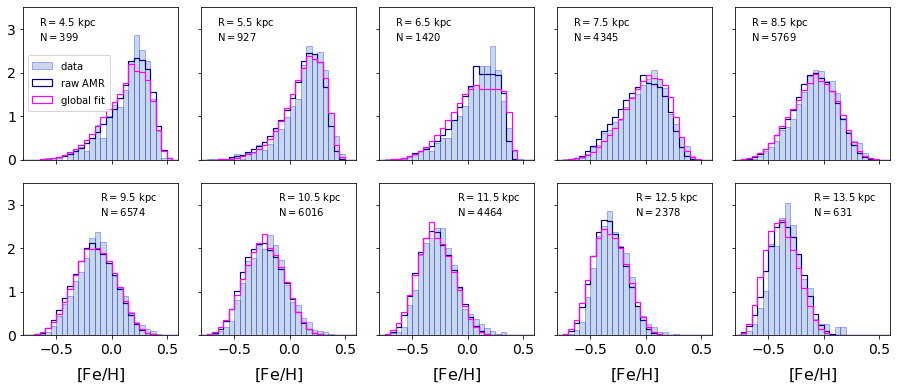

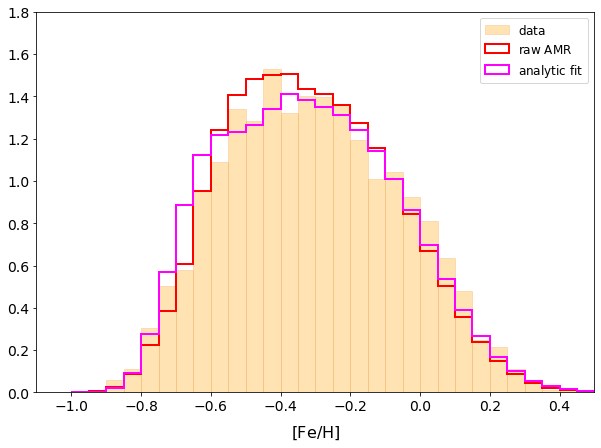

In [11]:
# Finally, we plot the results
# ----------------------------------
    
def plot_MDd(R,FeH_bins_histc2,FeH_bins_hist2,FeH_dist_data_al,histd_raw,histd_pfit,name):
    # Plots metallicity distributions of the thin disk in R-bins with normalization on area. 
    
    dFeH = np.mean(np.diff(FeH_bins_histc2))
    
    if p.dR==1.0:
        f, ax = plt.subplots(nrows=2,ncols=5,figsize=(14,6))
    if p.dR==0.5:
        f, ax = plt.subplots(nrows=3,ncols=7,figsize=(15,9))
    #f.suptitle('$\mathrm{Thin \ disk}$',fontsize=fnt1+2,y=0.95)
    for i in range(len(R)):
        Ndata = sum(FeH_dist_data_al[i])
        
        if p.dR==1.0:
            i1,i2 = int(i//5),int(i%5)
        if p.dR==0.5:
            i1,i2 = int(i//7),int(i%7)
        ax[i1,i2].hist(FeH_bins_histc2,bins=FeH_bins_hist2,density=True,weights=FeH_dist_data_al[i]/Ndata/dFeH,
                       color='steelblue',alpha=0.3,edgecolor='b',label='$\mathrm{data}$')
        ax[i1,i2].hist(FeH_bins_histc2,bins=FeH_bins_hist2,density=True,weights=histd_raw[i],
                       histtype='step',color='navy',label="$\mathrm{raw \ AMR}$",linewidth=1.2)
        ax[i1,i2].hist(FeH_bins_histc2,bins=FeH_bins_hist2,density=True,weights=histd_pfit[i],
                       histtype='step',color='magenta',label='$\mathrm{global \ fit}$',linewidth=1.2)
        ax[i1,i2].set_xlim(-0.8,0.6)
        ax[i1,i2].set_ylim(0,3.5)
        if i1==0:
            x1 = 0.1
        else:
            x1 = 0.5
        ax[i1,i2].text(x1,0.88,'$\mathrm{R=}$'+str(R[i])+'$\mathrm{ \ kpc}$',fontsize=10,
                      transform=ax[i1,i2].transAxes)
        ax[i1,i2].text(x1,0.78,'$\mathrm{N=}$'+str(int(Ndata)),fontsize=10,
                      transform=ax[i1,i2].transAxes)
        if p.dR==1.0:
            if i1==0:
                ax[i1,i2].set_xticklabels([])
            else:
                ax[i1,i2].set_xlabel('$\mathrm{[Fe/H]}$',fontsize=fnt1,labelpad=10)
            if i2!=0:
                ax[i1,i2].set_yticklabels([])
            if i1==0 and i2==0:
                ax[i1,i2].legend(loc='center left',prop={'size':10})
        if p.dR==0.5:
            if i1==2 or (i1==1 and (i2==5 or i2==6)):
                ax[i1,i2].set_xlabel('$\mathrm{[Fe/H]}$',fontsize=fnt1,labelpad=10)  
            else:
                ax[i1,i2].set_xticklabels([])
            if i2!=0:
                ax[i1,i2].set_yticklabels([])
    if len(R)<10:
        ax[1,4].set_axis_off()
    if p.dR==0.5:
        ax[2,6].set_axis_off()
        ax[2,6].set_axis_off()
        ax[2,6].hist(np.linspace(-10,-8,10),bins=2,color='steelblue',alpha=0.3,
                     edgecolor='b',label='$\mathrm{data}$')
        ax[2,6].hist(np.linspace(-10,-8,10),bins=2,color='navy',histtype='step',
                     label=r"$\mathrm{raw \ thin-disk \ AMR}$")
        ax[2,6].hist(np.linspace(-10,-8,10),bins=2,color='magenta',histtype='step',
                     label='$\mathrm{global \ fit}$')
        ax[2,6].legend(loc='center',prop={'size':fnt2})
        ax[2,6].set_xlim(-0.8,0.6)
    f.subplots_adjust(left=0.07,hspace=0.15,wspace=0.15,bottom=0.12,top=0.88,right=0.93)
    plt.show()
    f.savefig(os.path.join(a.T['metplt'],''.join(('MDd_global_fit_',name,'.pdf'))))


def plot_MDt(FeH_bins_histc2,FeH_bins_hist2,FeH_dist_data_ah,histt_raw,histt_fit,name):
    # Plots metallicity distribution of the thick disk with normalization on area. 

    dFeH = np.mean(np.diff(FeH_bins_histc2))
    Ndata = sum(FeH_dist_data_ah)
    
    f, ax = plt.subplots(figsize=(10,7))
    ax.hist(FeH_bins_histc2,bins=FeH_bins_hist2,density=True,weights=FeH_dist_data_ah/Ndata/dFeH,
            color='orange',alpha=0.3,edgecolor='sandybrown',label='$\mathrm{data}$')
    ax.hist(FeH_bins_histc2,bins=FeH_bins_hist2,density=True,weights=histt_raw,
            histtype='step',color='r',label=r"$\mathrm{raw \ AMR}$",linewidth=2)
    ax.hist(FeH_bins_histc2,bins=FeH_bins_hist2,density=True,weights=histt_fit,
            histtype='step',color='magenta',label='$\mathrm{analytic \ fit}$',linewidth=2)
    ax.set_xlim(-1.1,0.5)
    ax.set_ylim(0,1.8)
    ax.legend(loc=1,prop={'size':fnt2})
    ax.set_xlabel('$\mathrm{[Fe/H]}$',fontsize=fnt1,labelpad=10)
    plt.show()
    f.savefig(os.path.join(a.T['metplt'],''.join(('MDt_fit_',name,'.pdf'))))
    
    
# Read tables with the observed and predicted metallicity distributions 
#    data
md_d = np.loadtxt(os.path.join(a.T['mettab'],'FeH_N_d.txt')).T
md_t = np.loadtxt(os.path.join(a.T['mettab'],'FeH_N_t.txt')).T
#    model
histd_raw = np.loadtxt(os.path.join(a.T['mettab'],'FeH_dist_d_raw.txt')).T[1:]       
histd_fit = np.loadtxt(os.path.join(a.T['mettab'],'FeH_dist_d_fit.txt')).T[1:]
histt_raw = np.loadtxt(os.path.join(a.T['mettab'],'FeH_dist_t_raw.txt')).T[1]       
histt_fit = np.loadtxt(os.path.join(a.T['mettab'],'FeH_dist_t_fit.txt')).T[1]


# And make the plots
binsd = np.concatenate(([md_d[0][0]],md_d[1]),axis=0)
binsdc = [np.mean([i,k]) for (i,k) in zip(md_d[0],md_d[1])]
binst = np.concatenate(([md_t[0][0]],md_t[1]),axis=0)
binstc = [np.mean([i,k]) for (i,k) in zip(md_t[0],md_t[1])]

plot_MDd(a.R,binsdc,binsd,md_d[2:],histd_raw,histd_fit,'m2d_test')
plot_MDt(binstc,binst,md_t[2],histt_raw,histt_fit,'m2d_test')
          